In [1]:
# Imports
import numpy as np
import math
from deap import base, creator, tools
from numpy import random as rnd
import random
from draw_log import draw_log

In [2]:
def rastrigin(individual):
    n = len(individual)
    pi = np.pi
    dn = 1.0 / n
    a = 10.0
    b = 0.2
    c = 2 * pi
    s1 = 0.0
    s2 = 0.0
    for i in range(n):
        s1 += individual[i] * individual[i]
        s2 += np.cos(c*individual[i])
    s1 = -a * np.exp(-b*np.sqrt(dn*s1))
    s2 = -np.exp(dn*s2)
    result = s1+s2 + a + np.exp(1)
    result = -result
    result = result + a
    result = math.fabs(result)
    return result

In [3]:

def varOr(population, toolbox, lambda_, cxpb, mutpb):
    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = list(map(toolbox.clone, random.sample(population, 2)))
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            del ind2.fitness.values
            offspring.append(ind1)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(toolbox.clone(random.choice(population)))

    return offspring


def eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Vary the population
        if halloffame is not None:
            for ind in halloffame:
                population.append(toolbox.clone(ind))
        offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


In [17]:
def mutation(individual):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.75:
            individual[i] += rnd.normal(0.0, 0.2)
            individual[i] = np.clip(individual[i], -5, 5)
    return individual,
    

def function(x):
    res = rastrigin(x)
    return res,


class SimpleGAExperiment:
    def factory(self):
        return rnd.random(self.dimension) * 10 - 5

    def __init__(self, function, dimension, pop_size, iterations):
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = 0.9
        self.cross_prob = 0.7

        self.function = function
        self.dimension = dimension

        # self.pool = Pool(5)
        self.engine = base.Toolbox()
        # self.engine.register("map", self.pool.map)
        self.engine.register("map", map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register("population", tools.initRepeat, list, self.engine.individual, self.pop_size)
        self.engine.register("mate", tools.cxOnePoint)
        self.engine.register("mutate", tools.mutGaussian, mu=0.5, sigma=1.5, indpb=0.01)
        # self.engine.register("mutate", mutation)
        self.engine.register("select", tools.selTournament, tournsize=4)
        # self.engine.register("select", tools.selRoulette)
        self.engine.register("evaluate", self.function)

    def run(self):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, np.array_equal)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = eaMuPlusLambda(pop, self.engine, mu=self.pop_size, 
                                lambda_=int(self.pop_size*0.8), cxpb=self.cross_prob, 
                                mutpb=self.mut_prob, ngen=self.iterations,
                                stats=stats, halloffame=hof, verbose=True)
        print("Best = {}".format(hof[0]))
        print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log



In [18]:
creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

In [19]:
dimension = 100
pop_size = 100
iterations = 10000
scenario = SimpleGAExperiment(function, dimension, pop_size, iterations)
log = scenario.run()

gen	nevals	avg    	std     	min   	max    
0  	100   	3.92474	0.157788	3.5867	4.39321
1  	80    	4.11946	0.125998	3.90895	4.39321
2  	80    	4.27569	0.0888004	4.03204	4.46908
3  	80    	4.39311	0.0607143	4.23629	4.55835
4  	80    	4.44819	0.0478092	4.32421	4.55835
5  	80    	4.51663	0.0530316	4.39321	4.63837
6  	80    	4.60106	0.0643177	4.4734 	4.82752
7  	80    	4.6773 	0.0665782	4.55835	4.82752
8  	80    	4.76189	0.0711557	4.63604	4.87118
9  	80    	4.83128	0.0414889	4.70207	4.97945
10 	80    	4.89603	0.062335 	4.82294	5.02649
11 	80    	4.97668	0.0567985	4.84916	5.07125
12 	80    	5.04045	0.0318383	4.96443	5.12816
13 	80    	5.07579	0.0327676	5.02649	5.13973
14 	80    	5.11246	0.028368 	5.05237	5.16654
15 	80    	5.13998	0.0166047	5.0916 	5.18299
16 	80    	5.15656	0.0143693	5.12816	5.18299
17 	80    	5.17312	0.00977256	5.13798	5.18901
18 	80    	5.18272	0.00461314	5.16654	5.19141
19 	80    	5.18959	0.00549789	5.1763 	5.20496
20 	80    	5.19934	0.0121387 	5.18511	5.25339
21 	80    	

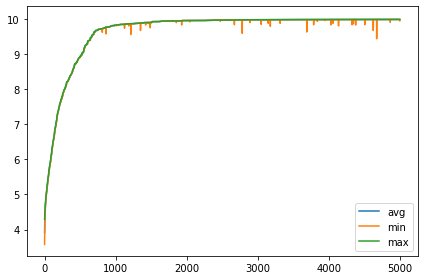

In [ ]:
draw_log(log)